# Sistem Rekomendasi Film Menggunakan Collaborative Filtering

## Project Overview
Sistem rekomendasi film bertujuan membantu pengguna menemukan film yang sesuai dengan preferensi mereka secara otomatis. Dengan banyaknya pilihan film, sistem ini dapat meningkatkan pengalaman pengguna dan membantu platform streaming meningkatkan engagement.

## Business Understanding
Permasalahan: Pengguna sering kesulitan memilih film yang sesuai dengan selera mereka di antara ribuan pilihan.
Solusi: Membangun sistem rekomendasi yang dapat memberikan saran film secara personal menggunakan pendekatan 

- **Collaborative Filtering**: Merekomendasikan film berdasarkan pola rating pengguna lain yang mirip.

## Data Understanding

Dataset MovieLens terdiri dari dua file utama:
- **movies.dat**: Informasi film (MovieID, Title, Genres)
- **ratings.dat**: Data rating yang diberikan user ke film (UserID, MovieID, Rating, Timestamp)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import pandas as pd

movies = pd.read_csv(
    'datasets/movies.dat',
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin1'
)
ratings = pd.read_csv(
    'datasets/ratings.dat',
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
    encoding='latin1'
)

display(movies.head())
display(ratings.head())

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Exploratory Data Analysis (EDA)

Analisis awal untuk mengetahui jumlah user, film, rating, dan distribusi rating.

In [4]:
print("Jumlah film unik:", movies['MovieID'].nunique())
print("Jumlah user unik:", ratings['UserID'].nunique())
print("Jumlah rating:", ratings.shape[0])
print("\nDistribusi rating:")
print(ratings['Rating'].value_counts().sort_index())

Jumlah film unik: 3883
Jumlah user unik: 6040
Jumlah rating: 1000209

Distribusi rating:
Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


## Data Preparation

Tahap ini bertujuan untuk membersihkan dan mempersiapkan data sebelum digunakan dalam pemodelan. Langkah-langkah yang dilakukan antara lain:
- Mengecek dan menangani missing value atau duplikasi data.
- Melakukan transformasi data jika diperlukan (misal: ekstraksi fitur genre, encoding, dsb.).
- Menyiapkan data agar siap digunakan untuk  collaborative filtering.

In [5]:
print("Missing value pada movies:\n", movies.isnull().sum())
print("Missing value pada ratings:\n", ratings.isnull().sum())
print("Duplikasi pada movies:", movies.duplicated().sum())
print("Duplikasi pada ratings:", ratings.duplicated().sum())

movies['MovieID'] = movies['MovieID'].astype(int)
ratings['UserID'] = ratings['UserID'].astype(int)
ratings['MovieID'] = ratings['MovieID'].astype(int)
ratings['Rating'] = ratings['Rating'].astype(int)

Missing value pada movies:
 MovieID    0
Title      0
Genres     0
dtype: int64
Missing value pada ratings:
 UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
Duplikasi pada movies: 0
Duplikasi pada ratings: 0


## Membagi Data untuk Training dan Validasi

Data rating dibagi menjadi 80% data training dan 20% data validasi.

In [6]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_val = train_test_split(
    ratings, test_size=0.2, random_state=42, shuffle=True
)

print("Jumlah data train:", ratings_train.shape[0])
print("Jumlah data validasi:", ratings_val.shape[0])

Jumlah data train: 800167
Jumlah data validasi: 200042


## Membuat User-Item Matrix

Matriks user-item dibuat dari data training untuk menghitung kemiripan antar user.

In [7]:
user_item_matrix = ratings_train.pivot_table(index='UserID', columns='MovieID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)

## Training Model Collaborative Filtering (Neural Network)

Pada tahap ini, model rekomendasi dibangun menggunakan embedding untuk user dan movie. Skor kecocokan dihitung dengan dot product embedding, ditambah bias, dan diaktivasi dengan sigmoid agar output berada di rentang [0, 1]. Model di-train menggunakan data training dan divalidasi pada data validasi.

In [8]:

# Siapkan data untuk training
min_rating = ratings['Rating'].min()
max_rating = ratings['Rating'].max()

# x_train dan x_val: pasangan (UserID, MovieID)
x_train = ratings_train[['UserID', 'MovieID']].values
x_val = ratings_val[['UserID', 'MovieID']].values

# y_train dan y_val: rating dinormalisasi ke [0, 1]
y_train = ratings_train['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y_val = ratings_val['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

num_users = ratings['UserID'].max() + 1  # pastikan ID mulai dari 0
num_movies = ratings['MovieID'].max() + 1

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

embedding_size = 50
model = RecommenderNet(num_users, num_movies, embedding_size)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 347s 27ms/step - loss: 0.6313 - root_mean_squared_error: 0.2614 - val_loss: 0.5901 - val_root_mean_squared_error: 0.2222
Epoch 2/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 282s 23ms/step - loss: 0.5839 - root_mean_squared_error: 0.2149 - val_loss: 0.5847 - val_root_mean_squared_error: 0.2155
Epoch 3/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 225s 18ms/step - loss: 0.5740 - root_mean_squared_error: 0.2030 - val_loss: 0.5841 - val_root_mean_squared_error: 0.2128
Epoch 4/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step - loss: 0.5664 - root_mean_squared_error: 0.1927 - val_loss: 0.5864 - val_root_mean_squared_error: 0.2125
Epoch 5/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - loss: 0.5601 - root_mean_squared_error: 0.1834 - val_loss: 0.5902 - val_root_mean_squared_error: 0.2139
Epoch 6/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 135s 11ms/step - loss: 0.5561 - root_mean_squared_error: 0.1763 - val_loss: 0.5943 - val_root_mean_squared_error: 0.2158
Epoch 7/10

##  Visualisasi hasil training

Grafik berikut menunjukkan perkembangan nilai Root Mean Squared Error (RMSE) pada data training dan validasi selama proses training model. Visualisasi ini membantu untuk memantau performa model, serta mendeteksi adanya overfitting atau underfitting pada proses pelatihan.

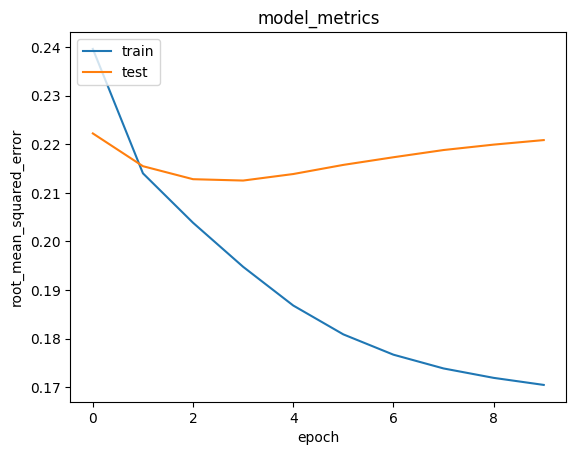

In [11]:
import matplotlib.pyplot as plt

# visualisasi loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sistem Rekomendasi Film Berdasarkan Model

Pada tahap ini, model yang telah dilatih digunakan untuk memberikan rekomendasi film kepada user. Sistem akan memprediksi skor kecocokan antara user dan seluruh film yang belum pernah dirating, lalu menampilkan film dengan skor prediksi tertinggi.

In [14]:
import numpy as np

def recommend_movies_for_user(user_id, model, movies, ratings, top_n=10):
    # Cari semua MovieID yang sudah dirating user
    movies_rated = ratings[ratings['UserID'] == user_id]['MovieID'].tolist()
    # Cari MovieID yang belum pernah dirating user
    movies_not_rated = movies[~movies['MovieID'].isin(movies_rated)]
    
    # Siapkan data prediksi: pasangan (user_id, movie_id)
    user_movie_array = np.array([[user_id, movie_id] for movie_id in movies_not_rated['MovieID']])
    
    # Prediksi skor dengan model
    ratings_pred = model.predict(user_movie_array, verbose=0).flatten()
    
    # Ambil indeks top_n skor tertinggi
    top_indices = ratings_pred.argsort()[-top_n:][::-1]
    recommended_movie_ids = movies_not_rated.iloc[top_indices]['MovieID'].values
    
    print(f"Rekomendasi untuk UserID: {user_id}")
    print("="*30)
    print("Film dengan rating tertinggi dari user:")
    print("-"*30)
    # Tampilkan 5 film dengan rating tertinggi yang pernah dirating user
    top_user_movies = (
        ratings[ratings['UserID'] == user_id]
        .sort_values(by='Rating', ascending=False)
        .head(5)
        .merge(movies, on='MovieID')
    )
    for row in top_user_movies.itertuples():
        print(f"{row.Title} : {row.Rating}")
    
    print("-"*30)
    print(f"Top {top_n} rekomendasi film:")
    print("-"*30)
    recommended_movies = movies[movies['MovieID'].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(f"{row.Title} : {row.Genres}")

# Contoh penggunaan
recommend_movies_for_user(user_id=4, model=model, movies=movies, ratings=ratings, top_n=10)

Rekomendasi untuk UserID: 4
Film dengan rating tertinggi dari user:
------------------------------
Hustler, The (1961) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Saving Private Ryan (1998) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
------------------------------
Top 10 rekomendasi film:
------------------------------
Shawshank Redemption, The (1994) : Drama
Schindler's List (1993) : Drama|War
Godfather, The (1972) : Action|Crime|Drama
Casablanca (1942) : Drama|Romance|War
Lawrence of Arabia (1962) : Adventure|War
Godfather: Part II, The (1974) : Action|Crime|Drama
Great Escape, The (1963) : Adventure|War
Sixth Sense, The (1999) : Thriller
Sanjuro (1962) : Action|Adventure
Double Indemnity (1944) : Crime|Film-Noir
